In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import math

# Load model and tokenizer
model_name = "meta-llama/Llama-3.2-3B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
# If no pad token is set, reuse the EOS token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

# Your text
text = "The quick brown fox jumps over the lazy dog."

# Tokenize
inputs = tokenizer(text, return_tensors="pt")
input_ids = inputs["input_ids"].to(model.device)

# Compute loss (negative log-likelihood)
with torch.no_grad():
    outputs = model(input_ids, labels=input_ids)
    loss = outputs.loss  # this is the mean cross-entropy loss over tokens

# Convert loss to perplexity
perplexity = math.exp(loss.item())

print(f"Perplexity: {perplexity}")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Perplexity: 5.485141753711975


In [2]:
def calculate_response_perplexity(model, tokenizer, input_text, response_text):
    """
    Calculate perplexity of a model response given the input.
    
    Args:
        model: The language model
        tokenizer: The tokenizer
        input_text: str - The original input/prompt
        response_text: str - The model's response to evaluate
    
    Returns:
        float: Perplexity of the response
    """
    
    # Tokenize input and response separately
    input_ids = tokenizer(input_text, return_tensors="pt", add_special_tokens=True)["input_ids"]
    response_ids = tokenizer(response_text, return_tensors="pt", add_special_tokens=False)["input_ids"]
    
    # Combine input and response
    full_sequence = torch.cat([input_ids, response_ids], dim=1).to(model.device).to(torch.int64)
    
    # Calculate the number of tokens in input vs response
    input_length = input_ids.shape[1]
    response_length = response_ids.shape[1]
    
    # Get model outputs for the full sequence
    with torch.no_grad():
        outputs = model(full_sequence)
        logits = outputs.logits  # Shape: [batch_size, sequence_length, vocab_size]
    
    # We want to evaluate the response tokens, so we need:
    # - logits for positions [input_length-1 : input_length+response_length-1]
    # - targets for positions [input_length : input_length+response_length]
    
    # Get logits for predicting response tokens
    response_logits = logits[0, input_length-1:input_length+response_length-1, :]  # [response_length, vocab_size]
    
    # Get target tokens (the actual response tokens)
    response_targets = full_sequence[0, input_length:input_length+response_length]  # [response_length]
    
    # Calculate cross-entropy loss for response tokens only
    loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
    loss = loss_fn(response_logits, response_targets)
    
    # Convert to perplexity
    perplexity = torch.exp(loss).item()
    
    return perplexity

In [3]:
def calculate_batch_response_perplexity_padded(model, tokenizer, input_texts, response_texts):
    """
    Calculate perplexities for a batch of responses using padding.
    This is the most straightforward but potentially less efficient approach.
    
    Args:
        model: The language model
        tokenizer: The tokenizer
        input_texts: List of input texts
        response_texts: List of corresponding response texts
    
    Returns:
        List[float]: Perplexities for each response
    """
    
    batch_size = len(input_texts)
    assert len(response_texts) == batch_size
    
    # Tokenize all sequences
    full_sequences = []
    input_lengths = []
    response_lengths = []
    
    for input_text, response_text in zip(input_texts, response_texts):
        input_ids = tokenizer(input_text, add_special_tokens=True)["input_ids"]
        response_ids = tokenizer(response_text, add_special_tokens=False)["input_ids"]
        full_seq = input_ids + response_ids
        
        full_sequences.append(full_seq)
        input_lengths.append(len(input_ids))
        response_lengths.append(len(response_ids))
    
    # Pad sequences to the same length
    max_length = max(len(seq) for seq in full_sequences)
    
    padded_sequences = []
    attention_masks = []
    
    for seq in full_sequences:
        print("doing")
        padded = seq + [tokenizer.pad_token_id] * (max_length - len(seq))
        mask = [1] * len(seq) + [0] * (max_length - len(seq))
        print(padded)
        
        padded_sequences.append(padded)
        attention_masks.append(mask)
    
    print(padded_sequences)
    print(type(model))
    # Convert to tensors
    input_ids = torch.tensor(padded_sequences).to(model.device)
    attention_mask = torch.tensor(attention_masks).to(model.device)
    
    # Get model outputs
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # [batch_size, seq_len, vocab_size]
    
    # Calculate perplexities for each sequence
    perplexities = []
    
    for i in range(batch_size):
        input_len = input_lengths[i]
        response_len = response_lengths[i]
        
        if response_len == 0:
            perplexities.append(float('inf'))
            continue
        
        # Get logits and targets for this response
        response_logits = logits[i, input_len-1:input_len+response_len-1, :]
        response_targets = input_ids[i, input_len:input_len+response_len]
        
        # Calculate loss
        loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
        loss = loss_fn(response_logits, response_targets)
        perplexity = torch.exp(loss).item()
        perplexities.append(perplexity)
    
    return perplexities

In [4]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from get_activations.utils import load_jsonl_data, format_prompts_from_pairs

human_list_on, assistant_list_on, full_list_on = load_jsonl_data("../data/refusal/on_policy_raw.jsonl")
human_list_off, assistant_list_off, full_list_off = load_jsonl_data("../data/refusal/off_policy_raw.jsonl")

In [6]:
perplexities_on = []
for i in range(len(human_list_on)):
    if i % 100 == 0:
        print(i)
    # if i >= 700:
    #     print(human_list[i])
    #     print(assistant_list[i])
    perplexity = calculate_response_perplexity(model, tokenizer, human_list_on[i], assistant_list_on[i])
    perplexities_on.append(perplexity)

0


100
200
300
400
500
600
700
800
900


In [7]:
perplexities_off = []
for i in range(len(human_list_off)):
    if i % 100 == 0:
        print(i)
    # if i >= 700:
    #     print(human_list[i])
    #     print(assistant_list[i])
    perplexity = calculate_response_perplexity(model, tokenizer, human_list_off[i], assistant_list_off[i])
    perplexities_off.append(perplexity)

0


100
200
300
400
500
600
700
800
900


In [9]:

import numpy as np
print(np.array(perplexities_on).dtype)
print(perplexities_off)

float64
[18.26664924621582, 8.194799423217773, 10.017582893371582, 8.84039306640625, 17.656394958496094, 5.308177471160889, 20.763835906982422, 18.590625762939453, 10.905220985412598, 30.97357940673828, 25.881153106689453, 15.373830795288086, 28.778446197509766, 12.70141315460205, 7.660299301147461, 11.88512897491455, 17.942880630493164, 8.67232608795166, 8.370097160339355, 14.246521949768066, 354.59033203125, 20.977783203125, 4.620357036590576, 7.101224899291992, 26.107789993286133, 94.34821319580078, 12.72055435180664, 27.021305084228516, 205.9989013671875, 40.04661560058594, 22.653249740600586, 19.695356369018555, 6.083626747131348, 9.081298828125, 39.66306686401367, 23.241817474365234, 41.80951690673828, 7.441888332366943, 10.205533981323242, 9.572132110595703, 8.808295249938965, 12.829660415649414, 62.1129150390625, 9.332795143127441, 8.574864387512207, 14.155535697937012, 12.794337272644043, 13.887300491333008, 7.283447265625, 14.894753456115723, 7.895694255828857, 25.46986961364

In [18]:
print(np.array(perplexities_on).min())
print(np.array(perplexities_off).max())
for i in range(len(perplexities_off)):
    if perplexities_off[i] == None:
        print(i)

1.0632638931274414
nan


In [26]:
arr = np.array(perplexities_off)
has_nan = np.isnan(arr).any()
print(f"Contains NaN: {has_nan}")

# Count how many NaNs
nan_count = np.isnan(arr).sum()
print(f"Number of NaNs: {nan_count}")

nan_indices = np.where(np.isnan(arr))[0]
print(f"NaN at indices: {nan_indices}")

arr = arr[np.isfinite(arr)]
has_nan = np.isnan(arr).any()
print(f"Contains NaN: {has_nan}")

# Count how many NaNs
nan_count = np.isnan(arr).sum()
print(f"Number of NaNs: {nan_count}")

nan_indices = np.where(np.isnan(arr))[0]
print(f"NaN at indices: {nan_indices}")
perplexities_off = arr

Contains NaN: True
Number of NaNs: 1
NaN at indices: [790]
Contains NaN: False
Number of NaNs: 0
NaN at indices: []


In [28]:
print(max(perplexities_off))

7201484.5


In [21]:
print(human_list_off[790])
print(assistant_list_off[790])

What are the best veggies to cook with potatoes?



In [29]:
def remove_large_outliers(data):
    arr = np.array(data)
    # Calculate the 99th percentile (threshold for top 1%)
    threshold = np.percentile(arr, 99)
    # Keep only values below this threshold
    filtered_arr = arr[arr < threshold]

    print(f"Original length: {len(arr)}")
    print(f"Filtered length: {len(filtered_arr)}")
    print(f"Removed {len(arr) - len(filtered_arr)} values (top 1%)")
    return filtered_arr

In [30]:
perplexities_on = remove_large_outliers(perplexities_on)
perplexities_off = remove_large_outliers(perplexities_off)

Original length: 1000
Filtered length: 990
Removed 10 values (top 1%)
Original length: 999
Filtered length: 989
Removed 10 values (top 1%)


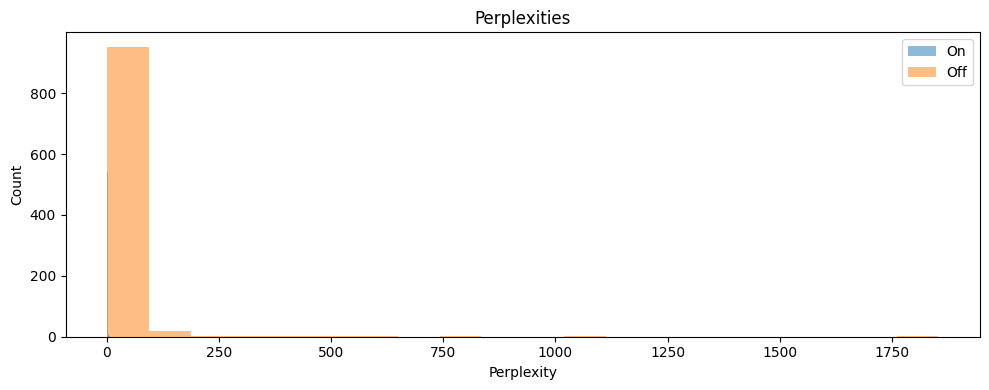

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 4))

plt.subplot(1, 1, 1)



plt.hist(perplexities_on, alpha=0.5, label='On', bins=20)
plt.hist(perplexities_off, alpha=0.5, label='Off', bins=20)
# plt.axvline(x = mean_on_distance, color = 'blue', linestyle='dashed', label = 'on_policy_mean')
# plt.axvline(x = mean_off_distance, color = 'orange', linestyle='dashed', label = 'off_policy_mean')
plt.xlabel('Perplexity')
plt.ylabel('Count')
plt.legend()
plt.title('Perplexities')

plt.tight_layout()
plt.show()

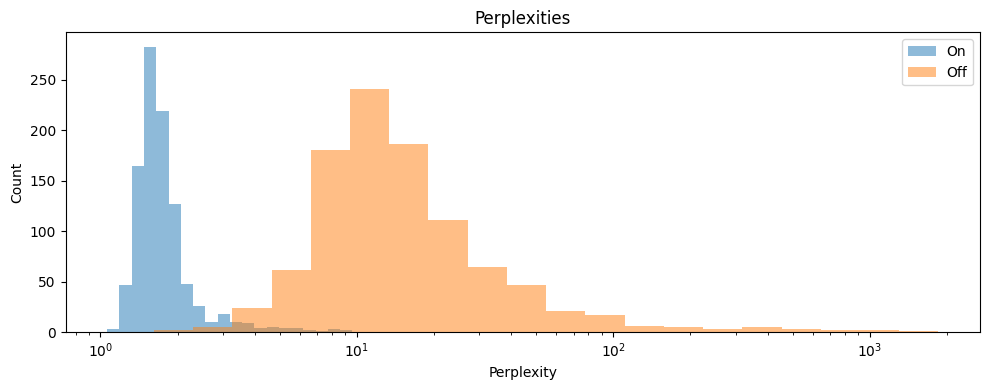

In [33]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 4))

plt.subplot(1, 1, 1)


hist, bins = np.histogram(perplexities_on, bins=20)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.hist(perplexities_on, alpha=0.5, label='On', bins=logbins)
plt.xscale('log')

hist, bins = np.histogram(perplexities_off, bins=20)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.hist(perplexities_off, alpha=0.5, label='Off', bins=logbins)
plt.xscale('log')

# plt.axvline(x = mean_on_distance, color = 'blue', linestyle='dashed', label = 'on_policy_mean')
# plt.axvline(x = mean_off_distance, color = 'orange', linestyle='dashed', label = 'off_policy_mean')
plt.xlabel('Perplexity')
plt.ylabel('Count')
plt.legend()
plt.title('Perplexities')

plt.tight_layout()
plt.show()

